In [1]:
from tensorflow.python.eager import backprop
from tensorflow.python.keras.engine import data_adapter
from tensorflow.python.keras.mixed_precision.experimental import loss_scale_optimizer as lso
from tensorflow.python.distribute import parameter_server_strategy
import tensorflow as tf


%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import colors
plt.style.use('seaborn-whitegrid')

In [1]:
import numpy as np
import cv2 as cv
import pandas as pd
import os

In [2]:
###Get dataset
mnist_train = pd.read_csv('Data/digit-recognizer/train.csv').astype(np.float32)
mnist_test = pd.read_csv('Data/digit-recognizer/test.csv').astype(np.float32)

In [213]:
#Helpful class for debuging. Shows images, convert image batches as matrix to rgb, rescales.
class Debug():
    class Image():
        def __init__(self,image,label=""):
            self.image = image
            self.label = label
            
    def show_images_list(image_list, labels = [], cmap = 'gray', col_number = 10, height = 2, save_name=None, save_dir = "Data/saved_images"):
        row = -(-len(image_list)//col_number) 
        fig = plt.figure(figsize=(15, row*height))
        count = 1
        
        if save_name:
            if not os.path.exists(save_dir):
                os.makedirs(save_dir)
        
        for i in range(len(image_list)):
            a = fig.add_subplot(row, col_number, count)
            plt.axis('off')
            if isinstance(i, Debug.Image):
                if image_list[i].label:
                    a.set_title(image_list[i].label)
                plt.imshow(image_list[i].image, cmap = cmap) 
            else:
                if any(labels):
                    a.set_title(labels[i])
                out_img = plt.imshow(image_list[i], cmap = cmap) 
            if save_name:
                plt.imsave(os.path.join(save_dir, "%s_%s.png"%(save_name,i)), image_list[i], cmap = cmap)
            count=count+1
            
    def show_image(img, cmap = 'gray'):
        plt.imshow(img, cmap = cmap) 
        
    def scale_to_1(x):
        return (x/255.0)
    
    def scale_to_255(x):
        return (x*255.0)
        
    def make_rgb_from_gray(img, mode="r"):
        img = img.reshape(-1,28,28,1)
        out_shape = list(img.shape)
        out_shape[-1] = 2
        out = np.concatenate((img, np.zeros(out_shape)), axis=3)
        if mode == "r":
            return out
        if mode == "g":
            return out[:,:,:,[1,0,2]]
        if mode == "b":
            return out[:,:,:,[1,2,0]]

#Example: debug_img_list.append(Debug.Image(img,"label"))
#Example: Debug.show_images_list(debug_img_list, col_number = 3, height = 5)

In [7]:
#y_train = np.array(mnist_train[['label']])[:,0]
#x_train = np.array(mnist_train[['pixel' + str(idx) for idx in range(784)]]).reshape([-1,28,28])

In [239]:
#Create n random conbination of 4-digits numbers
num_digits = 4
num_samples = 10

#Find minumum value of specific elements belong to one label
min_numbers = min(mnist_train['label'].value_counts())

#Create balanced data array with (10*min_numbers) elements =  (min_numbers "0" pics) + ... + (min_numbers "9" pics)
mnist_train_balanced = np.concatenate([np.array(mnist_train[mnist_train['label']==i].drop(columns=['label']))[0:min_numbers] for i in range(10)], axis=0)

#Make list of unique numbers combination
comb_ids = np.unique(np.array([np.random.randint(mnist_train_balanced.shape[0], size=num_digits) for i in range(num_samples*2)]),axis=0)[:num_samples]
print("Number of unique digits in each 0-9 class is %s"%min_numbers)
if comb_ids.shape[0] < num_samples:
    print("WARNING!!! List is shorter than required %s because of duplications, try to regenerate"%num_samples)
else:
    print("Successfully generated %s unique %s-digits combinations of numbers"%(num_samples,num_digits))
    
#make main array
generator_array = np.array([mnist_train_balanced[i] for i in comb_ids])

print("Shape of generator_array shape is", generator_array.shape)

Number of unique digits in each 0-9 class is 3795
Successfully generated 10 unique 4-digits combinations of numbers
Shape of generator_array shape is (10, 4, 784)


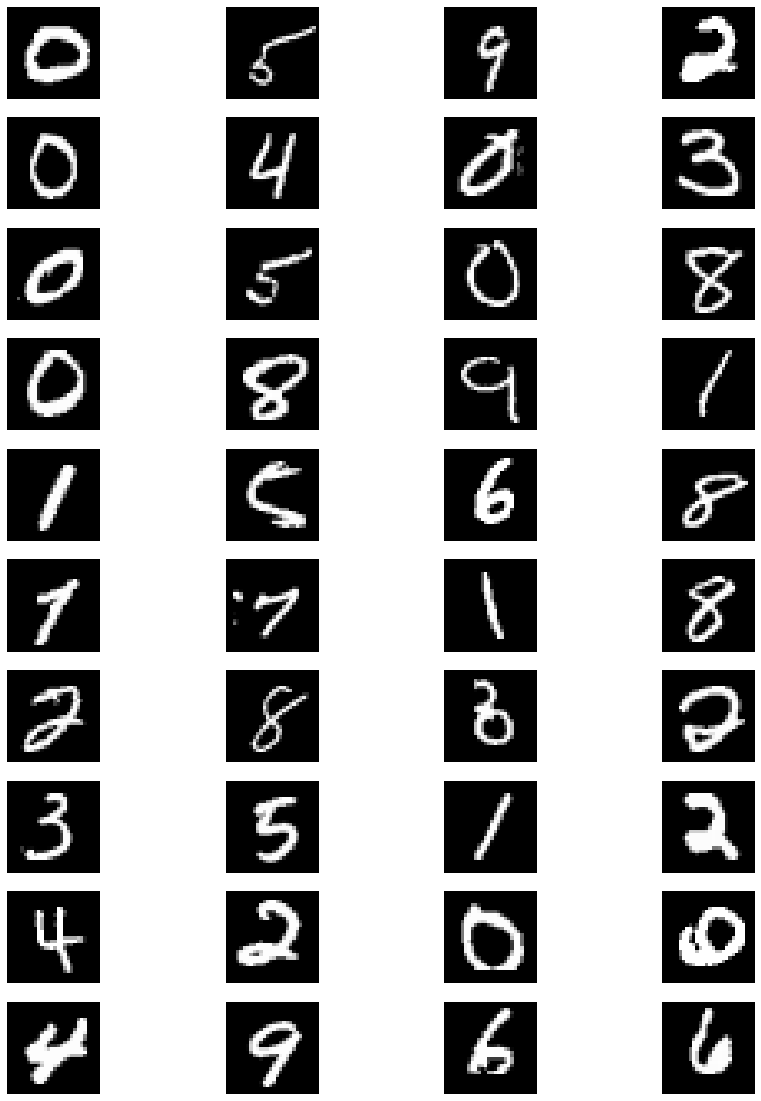

In [288]:
#Show first 3 group
Debug.show_images_list(generator_array[:10].reshape(-1,28,28), col_number = 4)

out shape is (10, 32, 84)


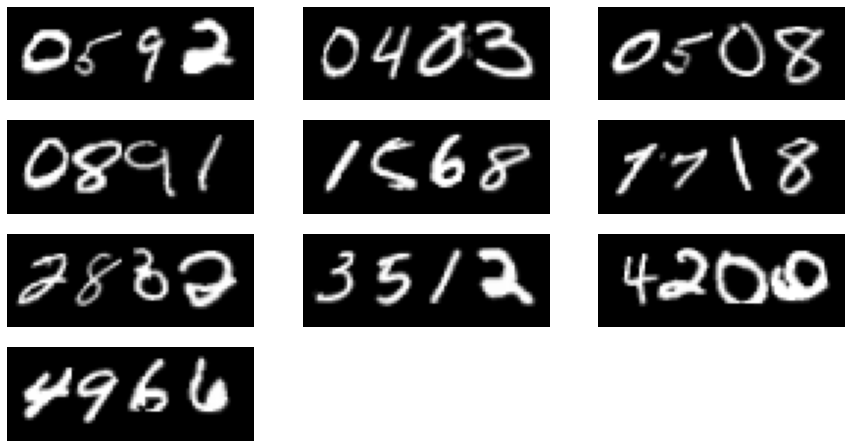

In [553]:
class Image_generator(object):
    def __init__(self, num_digits=num_digits):
        self.layer_common_1_comb = Image_generator.Mod_combinator(num_digits=num_digits, delete_side_margin = 4)
        self.layer_common_2_pad = Image_generator.Mod_add_padding(pl=2, pr=2, pt=2, pb=2)
        self.layer_spec_1_transf = Image_generator.Mod_linear_transf(l=0.2, r=0.2, t = 0.2, b = 0.2, rand = True)
        
    def __call__(self, inp):
        res_common = self.layer_common_2_pad(self.layer_common_1_comb(inp))
        
        return self.layer_spec_1_transf(res_common)
    
    #Concantenate input digits to one long image
    class Mod_combinator(object):
        def __init__(self, num_digits, delete_side_margin = 0):
            self.delete_side_margin = delete_side_margin
            self.num_digits = num_digits
        def __call__(self, inp):
            #expect input matrix with shape (-1, num_samples, n, m)
            #where n*m - image
            shape = inp.shape[2]
            return np.concatenate([np.delete(inp[:,i,:,:], list(((k,shape-1-k) for k in range(self.delete_side_margin))), 2) for i in range(self.num_digits)], axis=2)
    
    #Add padding left, right, top, bottom
    class Mod_add_padding(object):
        def __init__(self, pl=2, pr=2, pt=2, pb=2):
            self.padd = (pl,pr,pt,pb)
        def __call__(self, inp):
            #expect input matrix with shape (-1, a, b)
            inp_shape = list(inp.shape)
            inp_shape_l = (inp_shape[0],inp_shape[1], self.padd[0])
            inp_shape_r = (inp_shape[0],inp_shape[1], self.padd[1])
            inp_shape_t = (inp_shape[0],self.padd[2], inp_shape[2]+self.padd[0]+self.padd[1])
            inp_shape_b = (inp_shape[0],self.padd[3], inp_shape[2]+self.padd[0]+self.padd[1])
            # np.concatenate([np.zeros(inp_shape_l), inp, np.zeros(inp_shape_r)], axis=2)
            return np.concatenate([np.zeros(inp_shape_t), np.concatenate([np.zeros(inp_shape_l), inp, np.zeros(inp_shape_r)], axis=2), np.zeros(inp_shape_b)], axis=1)
    
    #Add padding 
    class Mod_linear_transf(object):
        def __init__(self, l=0.0, r=0.0, t = 0.0, b = 0.0, rand = False):
            self.sc = (l/2,r/2,t/2,b/2)*np.random.rand(4) if rand else (l/2,r/2,t/2,b/2)
            
        def __call__(self, inp):
            w,h = inp.shape[2],inp.shape[1]
            tl, tr, bl, br = [0,0],[w-1,0],[0,h-1],[w-1,h-1]
            pts1 = np.float32([tl,tr,bl,br])
            pts2 = np.float32(
                np.floor([
                    [self.sc[2]*w, self.sc[0]*h],
                    [w-1-self.sc[2]*w, self.sc[1]*h],
                    [self.sc[3]*w, h-1-self.sc[0]*h],
                    [w-1-self.sc[3]*w, h-1-self.sc[1]*h]
                ])
            )
            M = cv.getPerspectiveTransform(pts1,pts2)

            return np.array([cv.warpPerspective(i,M,(w,h)) for i in inp])
        
#Each sample becomes separate class, thus we have num_classes = num_samples
#Create transformation pipeline object
img_gem = Image_generator(num_digits=num_digits)

generator_array_reshaped = generator_array.reshape(generator_array.shape[0],generator_array.shape[1],28,28)

result = img_gem(generator_array_reshaped)

print("out shape is",result.shape)

out = Debug.show_images_list(result, col_number = 3)

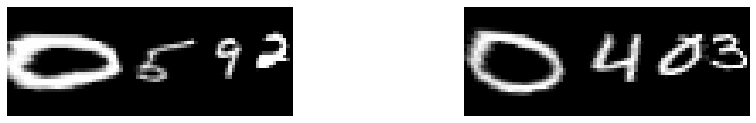

In [491]:


Debug.show_images_list(res, col_number = 2)


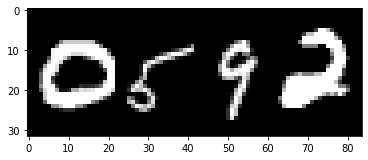

In [413]:
Debug.show_image(test_img)

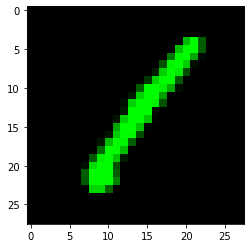

In [149]:
#Make red from gray
x_train_sc1 = Debug.scale_to_1(x_train)
x_train_Rgb = Debug.make_rgb_from_gray(x_train_sc1, mode="g")
Debug.show_image(x_train_Rgb[0])

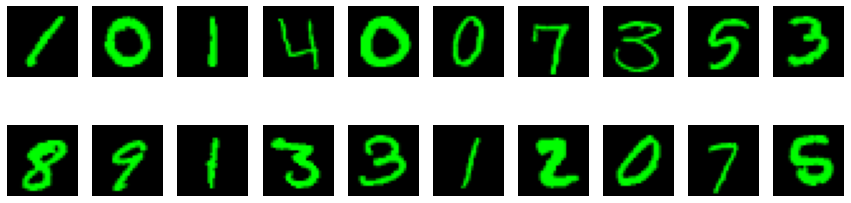

In [273]:
#$img = x_train[0].reshape([28,28])
out = Debug.show_images_list(x_train_Rgb)

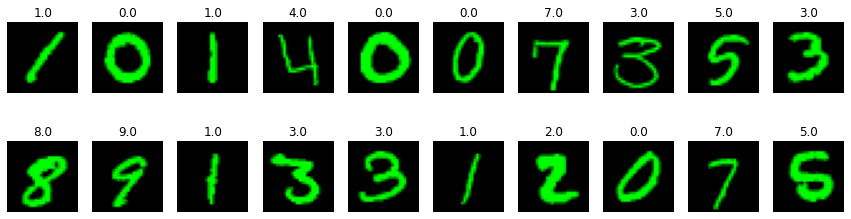

In [277]:
#Debug.show_image(img, cmap="gray")
#Debug.show_images_list(x_train_Rgb, y_train) #save_name="out"
Debug.show_images_list(x_train_Rgb, y_train, save_name="out") 

